1. procitati fajl
2. proveriti da li ima signala u svim kanalima
3. digitalno filtriranje
4. eliminisanje spajkova
5. naci maksimum pika
6. naci pocetak pika

In [1]:
from numba import jit
from scipy.optimize import curve_fit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [2]:
f = open('c:\DRS4 2013.04.26 22pf Coinc 2-3.dat','rb')

1 - struktura fajla - aktivni su bili samo kanali 2 i 3

In [3]:
#little endian
file_header_dtype = np.dtype([
    ("event header", "S4"),            # event header,  4-byte string
    ("serial_number", "<i4"),       # Serial number starting with 1  - integer
    ("year", "<H"),          # svih 8 je unsigned short - 
    ("month", "<H"),
    ("day", "<H"),
    ("hour", "<H"),             
    ("minute", "<H"),            
    ("second", "<H"),             
    ("milisecond", "<H"),
    ("reserved", "<H"),
    ("time_of_sample_bins", ("<f", (1024,))), #1024 4-byte float vreme
    ("channel_header2", "S4"), 
    ("data_channel2", ("<u2", (1024,))), # data 2-byte unsigned int
    ("channel_header3", "S4"),
    ("data_channel3", ("<u2", (1024,))), # data 2-byte unsigned int
   ])


In [4]:
file_header = np.fromfile(f, dtype=file_header_dtype, count=-1)

In [5]:
vreme = file_header["time_of_sample_bins"]

In [6]:
kanal2 = file_header["data_channel2"]

In [7]:
kanal3 = file_header["data_channel3"]

grafik sa podacima iz jednog iventa kanal 2 

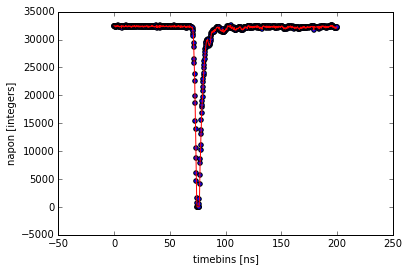

In [43]:
%matplotlib inline
x = vreme[0]
y = file_header["data_channel2"][0]
plt.scatter(x,y)
plt.plot(x, y, 'r')
plt.xlabel('timebins [ns]')
plt.ylabel('napon [integers]')
plt.show()

2  - provera da li ima signala u svim kanalima

In [8]:
#ovde trazimo min vrednosti u svakom kanalu
def vrednost_minimuma_u_kanalu(kanal):
    return np.min(kanal)

kanal2_= np.apply_along_axis(vrednost_minimuma_u_kanalu, 1, kanal2[:])


In [9]:
# kanal sa najvecom minimalnom vrednosti
max(kanal2_)

29281

In [10]:
#indeks kanala sa najvecom minimalnom vrednosti
np.nonzero(kanal2_ == 29281)

(array([16834], dtype=int64),)

In [11]:
#grafik kanala sa najvecom minimalnom vrednosti
x = vreme[16834]
y = file_header["data_channel2"][16834]
plt.scatter(x,y)
plt.plot(x, y, 'r')
plt.xlabel('timebins [ns]')
plt.ylabel('naponi [integers]')
plt.show()

C:\Users\PC\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


na osnovu slike kanala sa sumom koju si mi poslao,
zakljucio sam da nije bilo praznih kanala,
jer da ih je bilo ne bih dobio ovakav grafik za signal iz kanala sa najmanjim maksimumom napona

3 - digitalno filtriranje

In [8]:
@jit
def filtriranje(nefiltrirani):
    filtrirani = np.ones(1024)
    y2, y1 = nefiltrirani[:2]
    filtrirani[0] = nefiltrirani[0]
    filtrirani[1] = nefiltrirani[1]
    for i in range(2,1024):
        y = 0.20657 * nefiltrirani[i] + 0.41314 * nefiltrirani[i-1] \
        + 0.20657 * nefiltrirani[i-2] + 0.36953 * y1 - 0.19582 * y2
        filtrirani[i] = y
        y2 = y1
        y1 = y
    return filtrirani

In [9]:
#kanal2_filtrirani = np.apply_along_axis(filtriranje, 1, kanal2[:])

In [10]:
kanal2_filtrirani = np.apply_along_axis(filtriranje, 1, kanal2[:10000]) #samo deo iventova zbog memorije

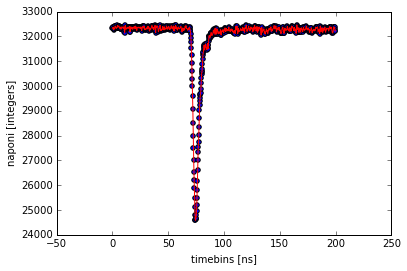

In [28]:
x = vreme[834]
y = kanal2_filtrirani[834]
plt.scatter(x,y)
plt.plot(x, y, 'r')
plt.xlabel('timebins [ns]')
plt.ylabel('naponi [integers]')
plt.show()

In [29]:
#kanal3_filtrirani = np.apply_along_axis(filtriranje, 1, kanal3[:])

4 - eliminisanje spajkova

In [30]:
@jit
def eliminisanje_spajkova(kanal):
    #usrednjavanje sa 6 tacaka levo i 6 desno
    for i in range(6, 1018):
        kanal[i] = (kanal[i-6] + kanal[i-5] + kanal[i-4] + kanal[i-3] + \
                    kanal[i-2] + kanal[i-1] + kanal[i] + kanal[i+1] + kanal[i+2] + \
                    kanal[i+3] + kanal[i+4] + kanal[i+5] + kanal[i+6]) / 13
    return kanal

In [12]:
#kanal2_filtrirani_i_eliminisani_spajkovi = np.apply_along_axis(eliminisanje_spajkova, 1, kanal2_filtrirani[:])

In [31]:
kanal2_filtrirani_i_eliminisani_spajkovi = np.apply_along_axis(eliminisanje_spajkova, 1, kanal2_filtrirani[:])\
# samo 10000 koji su gore filtrirani

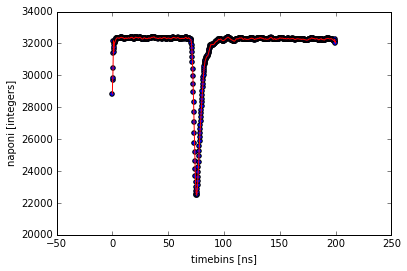

In [41]:
x = vreme[855]
y = kanal2_filtrirani_i_eliminisani_spajkovi[855]
plt.scatter(x,y)
plt.plot(x, y, 'r')
plt.xlabel('timebins [ns]')
plt.ylabel('naponi [integers]')
plt.show()

In [32]:
#kanal3_filtrirani_i_eliminisani_spajkovi = np.apply_along_axis(eliminisanje_spajkova, 1, kanal3_filtrirani[:])

5 - maksimum pika

fitovanje gausijanom,
kod uzet sa:
http://scipy-cookbook.readthedocs.org/items/FittingData.html#fitting-gaussian-shaped-data

In [78]:
#gaussian = lambda x: 3*np.exp(-(30-x)**2/20.)
primer =  -kanal2[30]/100
data = primer[260:520]
plt.plot(data, '.')

X = np.arange(data.size)
x = np.sum(X*data)/np.sum(data)
width = np.sqrt(np.abs(np.sum((X-x)**2*data)/np.sum(data)))

max = data.max()

fit = lambda t : max*np.exp(-(t-x)**2/(2*width**2))

plt.plot(fit(X), '-')
plt.show()



In [79]:
#sa filtriranim 
#gaussian = lambda x: 3*np.exp(-(30-x)**2/20.)
primer =  kanal2_filtrirani[30]/100
data = primer[280:500]
plt.plot(data, '.')

X = np.arange(data.size)
x = np.sum(X*data)/np.sum(data)
width = np.sqrt(np.abs(np.sum((X-x)**2*data)/np.sum(data)))

max = data.max()

fit = lambda t : max*np.exp(-(t-x)**2/(2*width**2))

plt.plot(fit(X), '-')
plt.show()



In [70]:

from scipy import optimize

class Parameter:
    def __init__(self, value):
            self.value = value

    def set(self, value):
            self.value = value

    def __call__(self):
            return self.value

def fit(function, parameters, y, x = None):
    def f(params):
        i = 0
        for p in parameters:
            p.set(params[i])
            i += 1
        return y - function(x)

    if x is None: x = np.arange(y.shape[0])
    p = [param() for param in parameters]
    return optimize.leastsq(f, p)



In [69]:
# giving initial parameters
mu = Parameter(7)
sigma = Parameter(3)
height = Parameter(5)

# define your function:
def f(x): return height() * np.exp(-((x-mu())/sigma())**2)

# fit! (given that data is an array with the data to fit)
data = -kanal2[1]
print fit(f, [mu, sigma, height], data)


(array([   461.1328155 ,  -1469.06089576,  35972.50068527]), 1)


In [82]:
x = vreme[100][260:520]
y = -kanal2_filtrirani[100][260:520]


def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

p0 = [1., 0., 1.]

coeff, var_matrix = curve_fit(gauss,x, y, p0=p0)

# Get the fitted curve
hist_fit = gauss(x, *coeff)

plt.plot(x, y, label='Test data')
plt.plot(x, hist_fit, label='Fitted data')

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print 'Fitted mean = ', coeff[1]
print 'Fitted standard deviation = ', coeff[2]

plt.show()

Fitted mean =  0.0
Fitted standard deviation =  1.0


In [87]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

x = vreme[30][260:520]
y = -kanal2[30][260:520]

n = len(x)                          #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-mean)**2)/n        #note this correction

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()
plt.title('Fig. 3 - Fit for Time Constant')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()

In [44]:
from numpy import sqrt, pi, exp, linspace, loadtxt
from lmfit import  Model

import matplotlib.pyplot as plt

#data = loadtxt('model1d_gauss.dat')
x = vreme[28][260:520]
y = kanal2_filtrirani[28][260:520]

def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return (amp/(sqrt(2*pi)*wid)) * exp(-(x-cen)**2 /(2*wid**2))

gmod = Model(gaussian)
result = gmod.fit(y, x=x, amp=5, cen=5, wid=1)

print(result.fit_report())

plt.plot(x, y,         'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 260
    # variables        = 3
    chi-square         = 240760972504.112
    reduced chi-square = 936813122.584
    Akaike info crit   = 5377.079
    Bayesian info crit = 5387.761
[[Variables]]
    amp:   5          +/- 0        (0.00%) (init= 5)
    cen:   5          +/- 0        (0.00%) (init= 5)
    wid:   1.00000001 +/- 0        (0.00%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)



In [46]:
f.close()

AttributeError: 'function' object has no attribute 'close'

In [157]:
who_ls

['broj_tacaka',
 'eliminisanje_spajkova',
 'elspajk',
 'f',
 'file_header',
 'file_header_dtype',
 'filtriranje2',
 'i',
 'jit',
 'kanal2',
 'kanal3',
 'kanalica',
 'kanalica2',
 'kanalica2_eliminisani',
 'kanalica3',
 'kanalica4',
 'kanalica4_eliminisani',
 'kanalica5',
 'matplotlib',
 'n',
 'np',
 'plt',
 'vreme']

In [60]:
#%reset_selective -f file_header